# 4. Application de régression sur le Boston dataset

Dans ce notebook, nous cherchons à déterminer les incertitudes sur un jeu de données multi-varié simple: le Boston dataset.

## Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Boston dataset

### Importation des données

In [3]:
dict_boston = load_boston()

In [4]:
X = pd.DataFrame(dict_boston['data'], columns=dict_boston['feature_names'])
y = pd.DataFrame(dict_boston['target'], columns=['MEDV'])

In [5]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
num_col_ids, cat_col_ids = [], []
for icol, col in enumerate(X.columns):
    if len(X[col].unique()) < 10:
        cat_col_ids.append(icol)
    else:
        num_col_ids.append(icol)
num_cols = X.columns[num_col_ids]
cat_cols = X.columns[cat_col_ids]
target_col = 'MEDV'
X_cat = X.loc[:, cat_cols]
unique_cat = [np.unique(X_cat.iloc[:, i]) for i in range(X_cat.shape[1])]

Les données contiennent 13 variables indépendantes de type `float`, 11 d'entre elles sont numériques, et 2 sont catégorielles:
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) categorical
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways categorical
- TAX full-value property-tax rate per \$10,000
- PTRATIO pupil-teacher ratio by town
- B $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town
- LSTAT \% lower status of the population

Target variable:
- MEDV Median value of owner-occupied homes in \$1000’s

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Pré-traitement des données

In [8]:
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
        ("encoder", OneHotEncoder(
            categories=unique_cat,
            drop=None,
            sparse=False,
            handle_unknown="ignore"
        ))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0
)

In [9]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [10]:
X_train_prep.shape, X_test_prep.shape

((404, 22), (102, 22))

### Modélisation

#### Première approche par un MLP déterministe

In [11]:
def get_probabilistic_mlp(
    shape,
    hidden_type= "dense",
    output_type = "deterministic",
    hidden_units = [1],
    activations = ["relu"],
    mcdropout = 0.,
    prior = None,
    posterior = None,
    loss = "mean_squared_error",
    optimizer = "adam",
    verbose = 1
) -> Model:
    """
    Define a probabilistic MultiLayer Perceptron architecture from specified hidden
    units and activation functions, type of hidden and output layers, and functions
    for prior and posterior distributions, and compile the network.
    """
    inputs = Input(shape=(shape[1],))
    x = inputs
    for i, units in enumerate(hidden_units):
        if hidden_type == "variationaldense":
            x = tfpl.DenseVariational(
                units=units,
                make_prior_fn=prior,
                make_posterior_fn=posterior,
                kl_weight=1/shape[0],
                activation=activations[i]
            )(x)
        else:
            x = Dense(units, activation=activations[i])(x)
            if mcdropout > 0:
                x = Dropout(mcdropout)(x, training=True)
    if output_type == "probabilistic":
        x = Dense(tfpl.IndependentNormal.params_size(event_shape=1))(x)
        outputs = tfpl.IndependentNormal(event_shape=1)(x)
    else:
        outputs = Dense(units=1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    if output_type == 'probabilistic':
        loss = negative_log_likelihood
    model.compile(loss=loss, optimizer=optimizer)
    return model

#### Estimation de l'incertitude résiduelle par un MLP probabiliste

In [12]:
def negative_log_likelihood(y_true, y_pred):
    """Negative log likelihood."""
    return -y_pred.log_prob(y_true)

In [13]:
%%time
mlp_determ = get_probabilistic_mlp(
    shape=X_train_prep.shape, 
    hidden_type="dense", 
    output_type="deterministic", 
    hidden_units=[32, 32], 
    activations=["sigmoid", "sigmoid"],
    optimizer=Adam(learning_rate=0.01)
)
early_stopping = EarlyStopping(monitor="val_loss", patience=50)
hist_determ = mlp_determ.fit(
    X_train_prep,
    y_train, 
    epochs=1000, 
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
y_determ_train = mlp_determ.predict(X_train_prep)
y_determ_pred = mlp_determ.predict(X_test_prep)

Epoch 1/1000
12/12 [==============================] - 1s 35ms/step - loss: 464.4050 - val_loss: 346.8454
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 327.2701 - val_loss: 243.5020
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 231.7307 - val_loss: 176.3623
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 170.2636 - val_loss: 130.3848
Epoch 5/1000
12/12 [==============================] - 0s 4ms/step - loss: 131.1795 - val_loss: 101.6012
Epoch 6/1000
12/12 [==============================] - 0s 5ms/step - loss: 103.5085 - val_loss: 82.2103
Epoch 7/1000
12/12 [==============================] - 0s 5ms/step - loss: 93.9056 - val_loss: 71.5942
Epoch 8/1000
12/12 [==============================] - 0s 5ms/step - loss: 73.4254 - val_loss: 64.9859
Epoch 9/1000
12/12 [==============================] - 0s 5ms/step - loss: 61.6057 - val_loss: 61.4223
Epoch 10/1000
12/12 [==============================] - 0s 5ms/step - l

In [14]:
%%time
mlp_aleatoric = get_probabilistic_mlp(
    shape=X_train_prep.shape, 
    hidden_type="dense", 
    output_type="probabilistic", 
    hidden_units=[32, 32], 
    activations=["sigmoid", "sigmoid"],
    optimizer=Adam(learning_rate=0.001)
)
early_stopping = EarlyStopping(monitor="val_loss", patience=50)
hist_aleatoric = mlp_aleatoric.fit(
    X_train_prep,
    y_train, 
    epochs=5000, 
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
y_aleatoric_train = mlp_aleatoric(X_train_prep)
y_aleatoric_train_sample = y_aleatoric_train.sample()
y_aleatoric_train_mean = y_aleatoric_train.mean()
y_aleatoric_train_std = y_aleatoric_train.stddev()
y_aleatoric = mlp_aleatoric(X_test_prep)
y_aleatoric_sample = y_aleatoric.sample()
y_aleatoric_mean = y_aleatoric.mean()
y_aleatoric_std = y_aleatoric.stddev()

Epoch 1/5000
12/12 [==============================] - 1s 16ms/step - loss: 197.6041 - val_loss: 127.7007
Epoch 2/5000
12/12 [==============================] - 0s 5ms/step - loss: 112.9749 - val_loss: 85.9750
Epoch 3/5000
12/12 [==============================] - 0s 5ms/step - loss: 86.1005 - val_loss: 64.2010
Epoch 4/5000
12/12 [==============================] - 0s 6ms/step - loss: 59.0308 - val_loss: 52.1470
Epoch 5/5000
12/12 [==============================] - 0s 5ms/step - loss: 50.3061 - val_loss: 44.2061
Epoch 6/5000
12/12 [==============================] - 0s 6ms/step - loss: 41.2825 - val_loss: 38.6652
Epoch 7/5000
12/12 [==============================] - 0s 6ms/step - loss: 36.8196 - val_loss: 34.5182
Epoch 8/5000
12/12 [==============================] - 0s 5ms/step - loss: 32.0686 - val_loss: 31.2825
Epoch 9/5000
12/12 [==============================] - 0s 5ms/step - loss: 28.7248 - val_loss: 28.6748
Epoch 10/5000
12/12 [==============================] - 0s 6ms/step - loss: 28.

#### Estimation de l'incertitude épistémique par un MLP bayésien avec couches internes `DenseVariational`

In [15]:
def prior(kernel_size, bias_size, dtype = None):
    """
    Multivariate Normal Diagonal non-trainable prior (loc=0, scale=1).
    """
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(
                loc=tf.zeros(n), scale_diag=tf.ones(n)
            )
        )
    ])
    return prior_model

In [16]:
def random_gaussian_initializer(shape, dtype):
    """
    Random gaussian initializer as defined in
    https://stackoverflow.com/questions/66418959/not-able-to-get-reasonable-results-from-densevariational
    """
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)


In [17]:
def posterior_mean_field(kernel_size, bias_size, dtype = None):
    """
    Mean-field posterior.
    More information can be found here:
    https://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/
    https://en.wikipedia.org/wiki/Variational_Bayesian_methods#Mean_field_approximation
    """
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return Sequential([
        tfpl.VariableLayer(
            2*n,
            dtype=dtype,
            initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype),
            trainable=True
        ),
        tfpl.DistributionLambda(
            lambda t: tfd.Independent(tfd.Normal(
                loc=t[..., :n],
                scale=1e-5 + 0.001*tf.nn.softplus(c + t[..., n:])
            ), reinterpreted_batch_ndims=1)
        ),
    ])


In [18]:
%%time
mlp_epistemic = get_probabilistic_mlp(
    shape=X_train_prep.shape, 
    hidden_type="variationaldense", 
    output_type="deterministic", 
    hidden_units=[32, 32], 
    activations=["sigmoid", "sigmoid"],
    loss="mean_squared_error",
    prior=prior,
    posterior=posterior_mean_field,
    optimizer=Adam(learning_rate=0.001)
)
early_stopping = EarlyStopping(monitor="val_loss", patience=200)
hist_epistemic = mlp_epistemic.fit(
    X_train_prep,
    y_train, 
    epochs=50000, 
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)
n_preds = 100
y_epistemic_train = np.stack([mlp_epistemic(X_train_prep) for _ in range(n_preds)])
y_epistemic_train_mean = np.mean(y_epistemic_train, axis=0) 
y_epistemic_train_std = np.std(y_epistemic_train, axis=0) 
y_epistemic = np.stack([mlp_epistemic(X_test_prep) for _ in range(n_preds)])
y_epistemic_mean = np.mean(y_epistemic, axis=0) 
y_epistemic_std = np.std(y_epistemic, axis=0) 

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Epoch 1/50000
12/12 [==============================] - 1s 33ms/step - loss: 717.3677 - val_loss: 658.2499
Epoch 2/50000
12/12 [==============================] - 0s 6ms/step - loss: 667.7823 - val_loss: 631.7546
Epoch 3/50000
12/12 [==============================] - 0s 6ms/step - loss: 616.2113 - val_loss: 607.0041
Epoch 4/50000
12/12 [==============================] - 0s 6ms/step - loss: 621.6314 - val_loss: 583.6718
Epoch 5/50000
12/12 [==============================] - 0s 7ms/step - loss: 601.7395 - val_loss: 562.1334
Epoch 6/50000
12/12 [==============================] - 0s 6ms/step - loss: 551.0188 - val_loss: 542.3060
Epoch 7/50000
12/12 [==============================] - 0s 6ms/step - loss: 514.2076 - val_loss: 524.4539
Epoch 8/50000
12/12 [==============================] - 0s 6ms/step - loss: 548.2997 - val_loss: 508.1932
Epoch 9/50000
12/12 [==============================] - 0s 7ms/step - los

In [25]:
from sklearn.metrics import mean_squared_error
pd.DataFrame([
    mean_squared_error(y_test, y_determ_pred),
    mean_squared_error(y_test, y_aleatoric_mean.numpy()),
    mean_squared_error(y_test, y_epistemic_mean)
], index=["Deterministic MLP", "Aleatoric MLP", "Epistemic MLP"],
columns=["MSE"])

,MSE
Deterministic MLP,12.252170
Aleatoric MLP,12.585811
Epistemic MLP,11.475420


#### Visualisation des résultats

In [26]:
def plot_loss_history(
    history,
    plot_val = False,
    title = None,
    y_scale = "linear",
    legend = None,
    ax = None
):
    """
    Plot loss as function of epochs.
    """
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    if isinstance(history, list):
        lss = ["-", "--", "-."]
        for i, hist in enumerate(history):
            ax.plot(hist.history["loss"], label=history[i], ls=lss[i], color=f"C0")
            if plot_val:
                ax.plot(hist.history["val_loss"], label="Validation Loss", color=f"C1", ls=lss[i])
    else:
        ax.plot(history.history["loss"], label="Loss")
        if plot_val:
            ax.plot(history.history["val_loss"], label="Validation Loss")
    if title is not None:
        ax.set_title(title)
    ax.set_yscale(y_scale)
    if legend is None:
        ax.legend()
    else:
        ax.legend(legend)

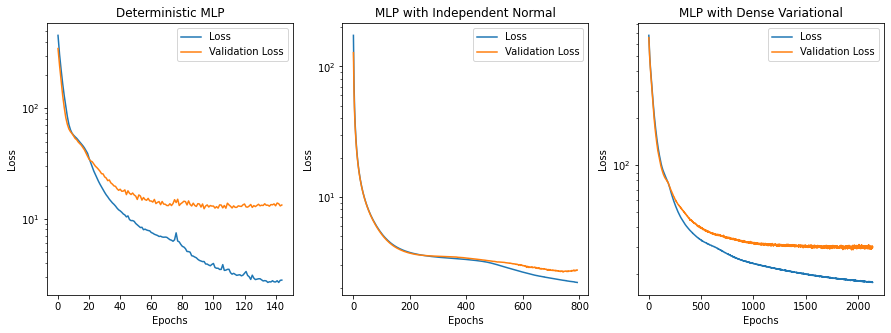

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
titles = [
    "Deterministic MLP",
    'MLP with Independent Normal',
    'MLP with Dense Variational'
]
hists = [hist_determ, hist_aleatoric, hist_epistemic]
for i, hist in enumerate(hists):
    plot_loss_history(hist, plot_val=True, title=titles[i], y_scale='log', ax=axs[i])

In [28]:
def plot_ytrue_vs_ypred(
    y_train,
    y_train_pred_mean,
    y_train_pred_std,
    y_test,
    y_pred_mean,
    y_pred_std,
    ax
):
    ax.errorbar(x=y_train, y=y_train_pred_mean, yerr=y_train_pred_std, alpha=0.8, label="train", fmt=".")
    ax.errorbar(x=y_test, y=y_pred_mean, yerr=y_pred_std, alpha=0.8, label="test", fmt=".")
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color="gray", alpha=0.5)
    ax.set_xlabel("True values", fontsize=12)
    ax.set_ylabel("Predicted values", fontsize=12)
    ax.legend()


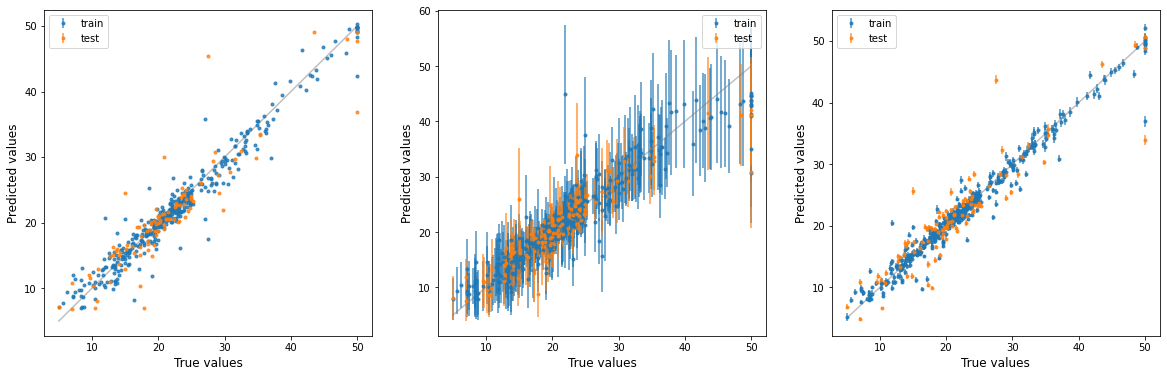

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
y_train_means = [y_determ_train.ravel(), y_aleatoric_train_mean.numpy().ravel(), y_epistemic_train_mean.ravel()]
y_train_stds = [np.zeros_like(y_determ_train.ravel()), y_aleatoric_train_std.numpy().ravel(), y_epistemic_train_std.ravel()]
y_test_means = [y_determ_pred.ravel(), y_aleatoric_mean.numpy().ravel(), y_epistemic_mean.ravel()]
y_test_stds = [np.zeros_like(y_determ_pred.ravel()), y_aleatoric_std.numpy().ravel(), y_epistemic_std.ravel()]
for i, title in enumerate(['deterministic', 'aleatoric', 'epistemic']):
    plot_ytrue_vs_ypred(
        y_train.to_numpy().ravel(),
        y_train_means[i],
        1.96*y_train_stds[i],
        y_test.to_numpy().ravel(),
        y_test_means[i],
        1.96*y_test_stds[i],
        axs[i]
    )